In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pypsa

# compare network files
Solar capacity factor comparison over time


In [6]:
def compare_solar_capacity_factors(net1, net2, country_bus):
    # Filter solar generators in each network
    solar_generators_net1 = net1.generators[(net1.generators.carrier == 'solar') & (net1.generators.bus == country_bus)]
    solar_generators_net2 = net2.generators[(net2.generators.carrier == 'solar') & (net2.generators.bus == country_bus)]

    # Extract solar generators' p_max_pu for each network
    solar_p_max_pu_net1 = net1.generators_t.p_max_pu.loc[:, solar_generators_net1.index]
    solar_p_max_pu_net2 = net2.generators_t.p_max_pu.loc[:, solar_generators_net2.index]
    
    # Perform statistical analysis
    stats_net1 = solar_p_max_pu_net1.describe()
    stats_net2 = solar_p_max_pu_net2.describe()

    # Calculate the difference
    difference = solar_p_max_pu_net1.mean(axis=1) - solar_p_max_pu_net2.mean(axis=1)
    stats_difference = difference.describe()

    # Compare statistics
    comparison = pd.concat([stats_net1, stats_net2], axis=1, keys=['Network 1', 'Network 2'])

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    # Plot for Network 1 and Network 2
    axes[0].plot(solar_p_max_pu_net1.mean(axis=1), label='ERA5')
    axes[0].plot(solar_p_max_pu_net2.mean(axis=1), label='SARAH')
    axes[0].set_title('Solar Capacity Factors Over Time for Each Network')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Capacity Factor (p_max_pu)')
    axes[0].legend()
    # Annotate with statistics
    textstr = '\n'.join((
        f'ERA5 Mean: {stats_net1.loc["mean"].mean():.2f}',
        f'SARAH Mean: {stats_net2.loc["mean"].mean():.2f}'))
    axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, verticalalignment='top')

    # Plot for the difference
    axes[1].plot(difference, label='Difference (ERA5 - SARAH)', color='red')
    axes[1].set_title('Difference in Solar Capacity Factors Over Time')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Difference in Capacity Factor (p_max_pu)')
    axes[1].legend()
    # Annotate with statistics
    diff_textstr = '\n'.join((
        f'Mean Difference: {stats_difference.loc["mean"]:.2f}',
        f'Std Dev: {stats_difference.loc["std"]:.2f}'))
    axes[1].text(0.05, 0.95, diff_textstr, transform=axes[1].transAxes, verticalalignment='top')

    plt.tight_layout()
    plt.show()


    return comparison

In [7]:
n1 = pypsa.Network('../results/validationEU/networks/10/2025/DE/p1/2013/res100.nc')
n2 = pypsa.Network('../input/v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc')

#compare_solar_capacity_factors(n1, n2, 'IE5 0')

INFO:pypsa.io:Imported network res100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Network capacities generators links comparison

In [8]:
def plot_capacity_summaries(*networks):
    """
    Plots the summaries of capacity (p_nom) per carrier for each bus in given networks,
    and adds a subplot showing the difference in p_nom values between networks.
    Each dataframe is plotted in a subplot with consistent color coding for carriers.

    Parameters:
    *networks (variable number of pandas.DataFrame): networks to be plotted.
    """
    # Number of networks
    num_dfs = len(networks)

    # Creating subplots, with one extra for the difference plot
    fig, axes = plt.subplots(num_dfs + 1, 1, figsize=(10, 5 * (num_dfs + 1)))

    # Ensuring axes is a list even if there's only one subplot
    if num_dfs == 1:
        axes = [axes]

    # Initialize a DataFrame to store the summed values for difference calculation
    summed_values = []

    # Generate a consistent set of colors for carriers
    all_carriers = set()
    for network in networks:
        all_carriers.update(network.generators['carrier'].unique())
    colors = mcolors.XKCD_COLORS
    carrier_colors = {carrier: color for carrier, color in zip(all_carriers, colors)}
    carrier_colors.update({
        "offwind": "#6895dd",
        "offwind-ac": "#6895dd",
        "offwind-dc": "#6895dd",
        "onwind": "#74c6f2",
        "solar": "#ffef60",
        })

    for i, network in enumerate(networks):
        # Check if network has been solved and a valid p_nom_opt column exists
        if 'p_nom_opt' in network.generators.columns and not network.generators['p_nom_opt'].isna().any():
            capacity_column = 'p_nom_opt'
        else:
            capacity_column = 'p_nom'
            
        # Filtering only the relevant columns: 'bus', 'carrier', and 'p_nom'
        filtered_df = network.generators[['bus', 'carrier', capacity_column]]
        filtered_df.rename(columns={capacity_column: 'p_nom'}, inplace=True) if capacity_column != 'p_nom' else None

        # Group and sum the p_nom values per bus and carrier
        grouped_df = filtered_df.groupby(['bus', 'carrier']).sum().unstack().fillna(0)
        summed_values.append(grouped_df)

        # Plotting on the respective subplot with consistent colors
        (grouped_df/1000).plot(kind='bar', stacked=True, ax=axes[i], color=[carrier_colors[carrier] for carrier in grouped_df.columns.get_level_values(1)])
        axes[i].set_title(f'Sum of {capacity_column} per Carrier for each Bus (Network {i+1})')
        axes[i].set_xlabel('Bus')
        axes[i].set_ylabel(f'Sum of {capacity_column} [GW]')
        axes[i].grid(True, axis='y')
        
        #custom legend
        carrier_labels = [carrier for carrier in grouped_df.columns.get_level_values(1)]
        custom_legend = [plt.Line2D([0], [0], color=carrier_colors[carrier], lw=4) for carrier in carrier_labels]
        axes[i].legend(custom_legend, carrier_labels, title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Calculating and plotting the difference
    if num_dfs > 1:
        # Assuming only 2 networks for difference calculation
        difference_df = summed_values[1].subtract(summed_values[0], fill_value=0)
        (difference_df/1000).plot(kind='bar', stacked=True, ax=axes[-1], color=[carrier_colors[carrier] for carrier in difference_df.columns.get_level_values(1)])
        axes[-1].set_title('Difference in p_nom per Carrier for each Bus (Network 2 - Network 1)')
        axes[-1].set_xlabel('Bus')
        axes[-1].set_ylabel('Difference in Sum of p_nom [GW]')
        axes[-1].legend(custom_legend, carrier_labels, title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')

        # Annotation for total difference
        total_difference_per_carrier = difference_df.sum(axis=0)
        annotation_text = "\n".join([f"{carrier}: {total_diff / 1000:.2f} GW" for carrier, total_diff in total_difference_per_carrier.iteritems()])
        axes[-1].text(0.5, 0.5, annotation_text, transform=axes[-1].transAxes, ha='center', fontsize=10)
        axes[-1].grid(True, axis='y')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [9]:
def plot_link_capacity_summaries(*networks):
    """
    Plots the summaries of capacity (p_nom) per carrier for each link in given networks,
    filtering buses with carriers 'AC' or 'battery'.
    Each dataframe is plotted in a subplot with consistent color coding for link carriers.

    Parameters:
    *networks (variable number of pandas.DataFrame): networks to be plotted.
    """
    # Number of networks
    num_dfs = len(networks)

    # Creating subplots, with one extra for the difference plot
    fig, axes = plt.subplots(num_dfs + 1, 1, figsize=(10, 5 * (num_dfs + 1)))

    # Ensuring axes is a list even if there's only one subplot
    if num_dfs == 1:
        axes = [axes]
    
    # Initialize a DataFrame to store the summed values for difference calculation
    summed_values = []
    
    # Generate a consistent set of colors for carriers
    all_carriers = set()
    for network in networks:
        all_carriers.update(network.links['carrier'].unique())
    colors = mcolors.CSS4_COLORS
    carrier_colors = {carrier: color for carrier, color in zip(all_carriers, colors)}

    for i, network in enumerate(networks):
        # Filter for buses with 'AC' or 'battery' carriers
        ac_battery_buses = network.buses[network.buses.carrier.isin(['AC'])].index #'battery'

        # Filtering links with relevant buses and columns: 'bus1', 'carrier', and 'p_nom'
        filtered_links = network.links[network.links.bus1.isin(ac_battery_buses)]
        filtered_links = filtered_links[['bus1', 'carrier', 'p_nom']]

        # Group and sum the p_nom values per bus1 and carrier
        grouped_links = filtered_links.groupby(['bus1', 'carrier']).sum().unstack().fillna(0)
        summed_values.append(grouped_links)

        # Plotting on the respective subplot with consistent colors
        (grouped_links/1000).plot(kind='bar', stacked=True, ax=axes[i], color=[carrier_colors[carrier] for carrier in grouped_links.columns.get_level_values(1)])
        axes[i].set_title(f'Sum of p_nom per Carrier for each Link (Network {i+1})')
        axes[i].set_xlabel('Bus')
        axes[i].set_ylabel('Sum of p_nom [GW]')
        axes[i].grid(True, axis='y')
        axes[i].legend(title='Carrier')

            # Calculating and plotting the difference
    if num_dfs > 1:
        # Assuming only 2 networks for difference calculation
        difference_df = summed_values[1].subtract(summed_values[0], fill_value=0)
        (difference_df/1000).plot(kind='bar', stacked=True, ax=axes[-1], color=[carrier_colors[carrier] for carrier in difference_df.columns.get_level_values(1)])
        axes[-1].set_title('Difference in p_nom per Carrier for each Bus (DataFrame 2 - DataFrame 1)')
        axes[-1].set_xlabel('Bus')
        axes[-1].set_ylabel('Difference in Sum of p_nom [GW]')

        # Annotation for total difference
        total_difference_per_carrier = difference_df.sum(axis=0)
        annotation_text = "\n".join([f"{carrier}: {total_diff / 1000:.2f} GW" for carrier, total_diff in total_difference_per_carrier.iteritems()])
        axes[-1].text(0.5, 0.5, annotation_text, transform=axes[-1].transAxes, ha='center', fontsize=10)
        axes[-1].grid(True, axis='y')
        
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [10]:
# compare generator dataframe

def compare_generator_df(net1, net2):
    """
    Compare the generators dataframes of two PyPSA networks.
    
    :param net1: First PyPSA network object
    :param net2: Second PyPSA network object
    :return: DataFrame showing differences
    """
    # Extract generators dataframes
    gen1 = net1.generators
    gen2 = net2.generators

    # Align columns in both dataframes
    gen1, gen2 = gen1.align(gen2, axis=1)

    # Compare and find differences
    diff = pd.concat([gen1, gen2]).drop_duplicates(keep=False)

    return diff

## Comparison of input networks capacities (unsolved)

with comparing capacities I found a double attachment of vres capacities in pypsa-eur code.

INFO:pypsa.io:Imported network v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Index(['AL1 0 residential rural biomass boiler-2025',
       'AT1 0 residential rural biomass boiler-2025',
       'BA1 0 residential rural biomass boiler-2025',
       'BE1 0 residential rural biomass boiler-2025',
       'BG1 0 residential rural biomass boiler-2025',
       'CH1 0 residential rural biomass boiler-2025',
       'CZ1 0 residential rural biomass boiler-2025',
       'DE1 0 residential rural biomass boiler-2025',
       'DK1 0 residential rural biomass boiler-2025',
       'DK2 0 residential rural biomass boiler-2025',
       ...
       'MK1 0 services urban decentral biomass boiler-2025',
       'NL1 0 services urban decentral biomass boiler-2025',
       'NO2 0 services urban decentral biomass boiler-2025',
       'PL1 0 services urban decentral biomass boiler-2025',
       'PT1 0 services urban decentr

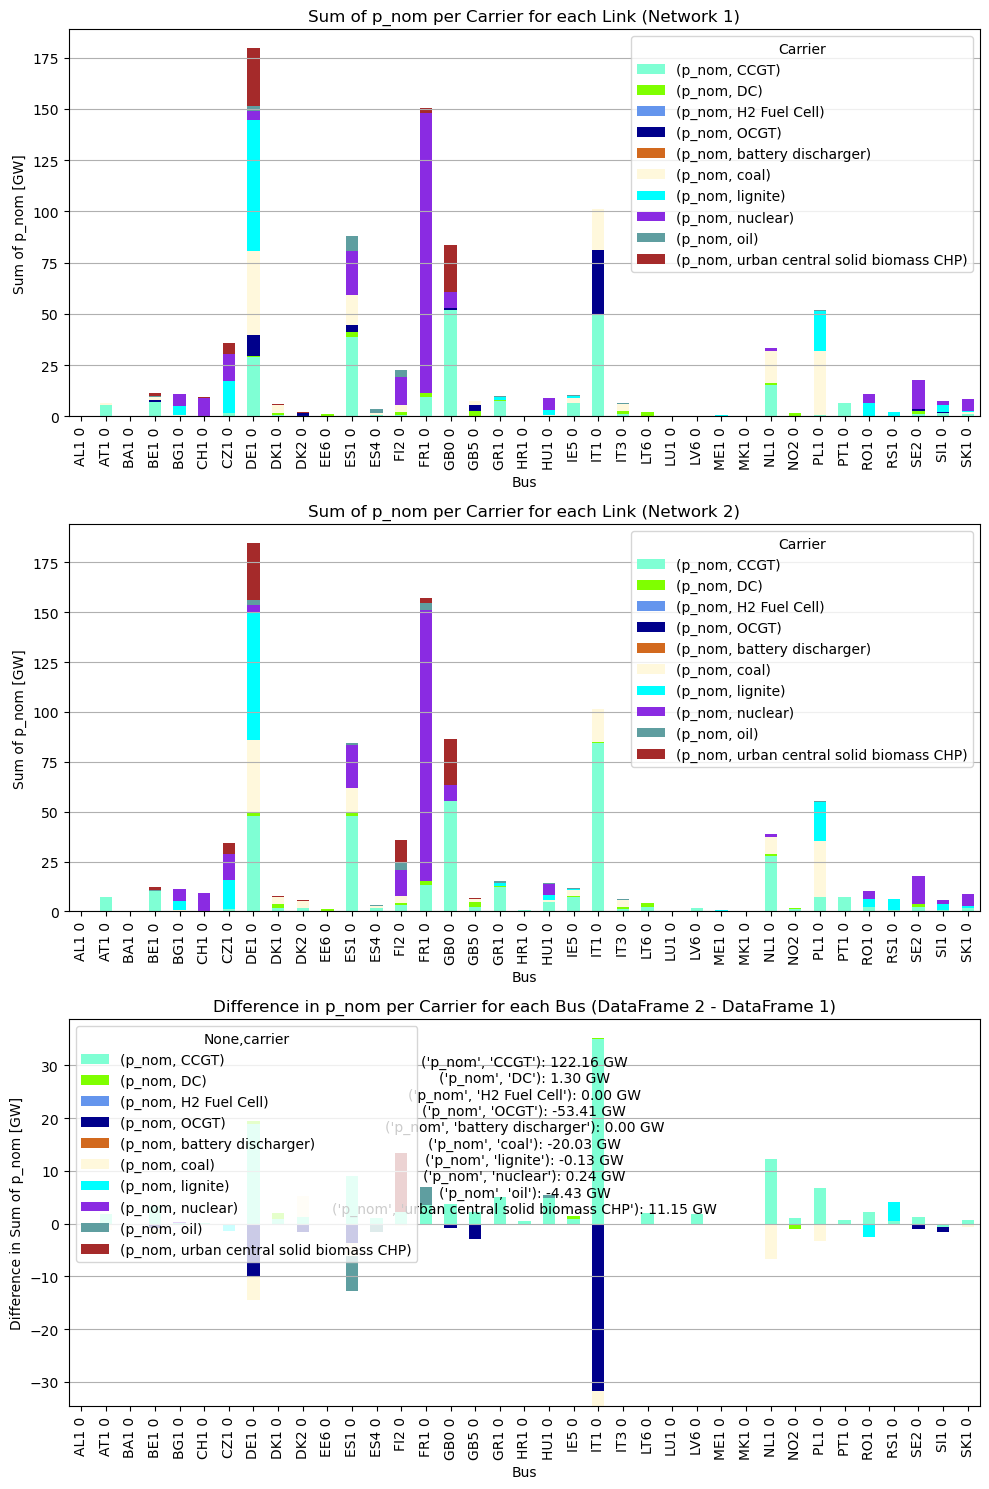

/tmp/ipykernel_6592/3454978569.py:76: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



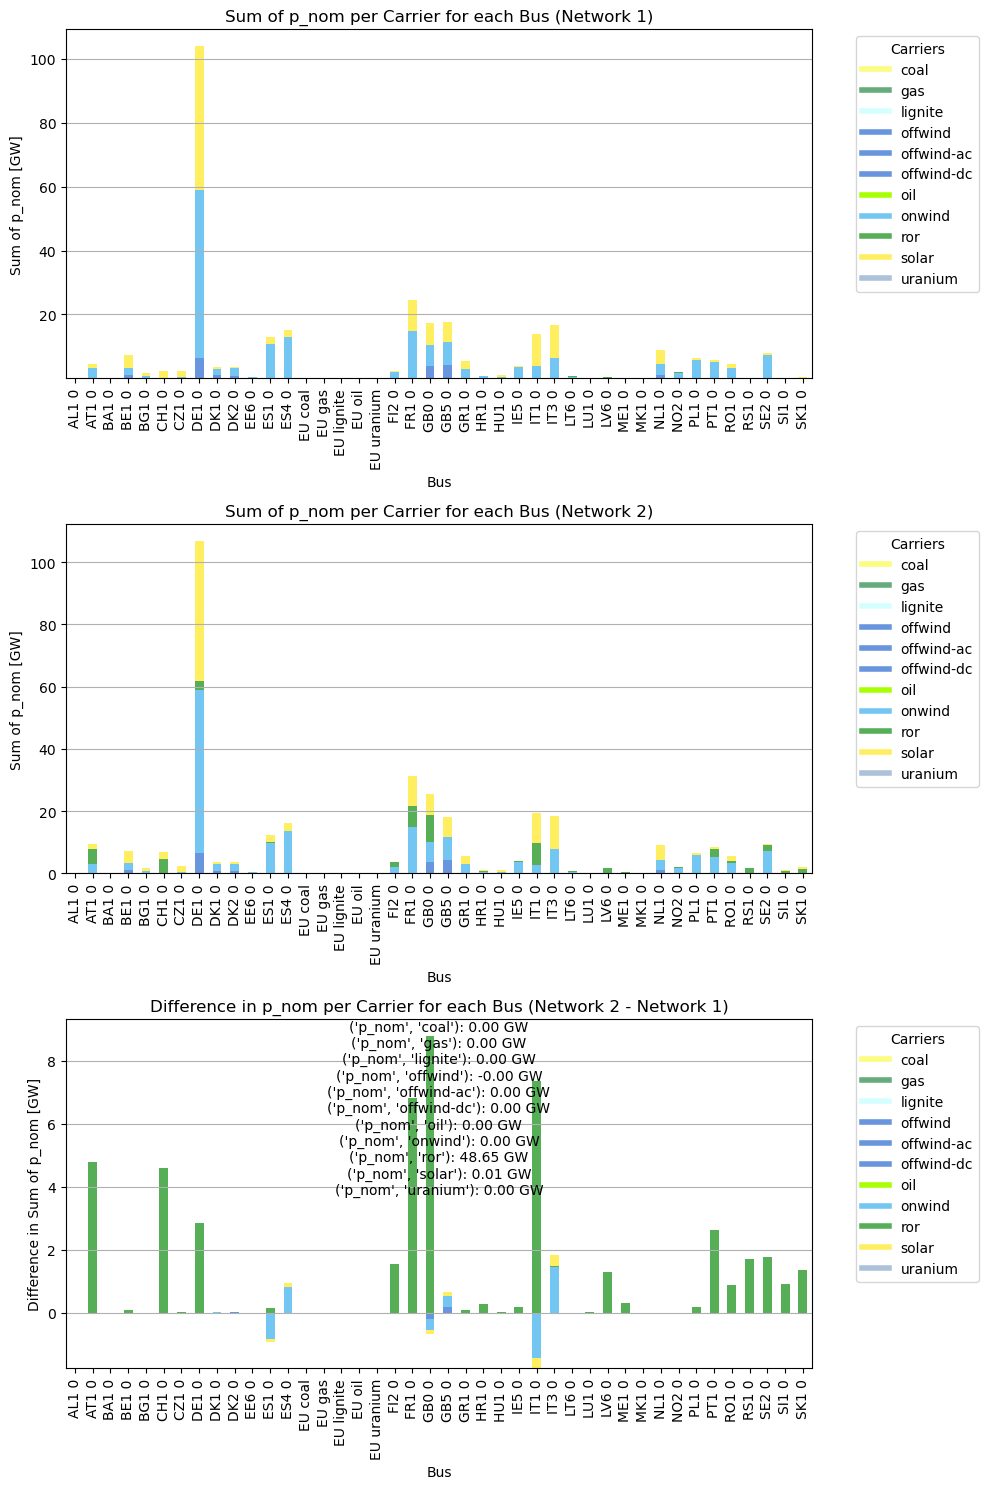

In [11]:
n1 = pypsa.Network('../input/v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc')
n2 = pypsa.Network('../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025_double_vre.nc')
plot_link_capacity_summaries(n1,n2)
plot_capacity_summaries(n1,n2)

tryna find the capacity differences in solved networks.

Index(['AL1 0 residential rural biomass boiler-2025',
       'AT1 0 residential rural biomass boiler-2025',
       'BA1 0 residential rural biomass boiler-2025',
       'BE1 0 residential rural biomass boiler-2025',
       'BG1 0 residential rural biomass boiler-2025',
       'CH1 0 residential rural biomass boiler-2025',
       'CZ1 0 residential rural biomass boiler-2025',
       'DE1 0 residential rural biomass boiler-2025',
       'DK1 0 residential rural biomass boiler-2025',
       'DK2 0 residential rural biomass boiler-2025',
       ...
       'MK1 0 services urban decentral biomass boiler-2025',
       'NL1 0 services urban decentral biomass boiler-2025',
       'NO2 0 services urban decentral biomass boiler-2025',
       'PL1 0 services urban decentral biomass boiler-2025',
       'PT1 0 services urban decentral biomass boiler-2025',
       'RO1 0 services urban decentral biomass boiler-2025',
       'RS1 0 services urban decentral biomass boiler-2025',
       'SE2 0 services

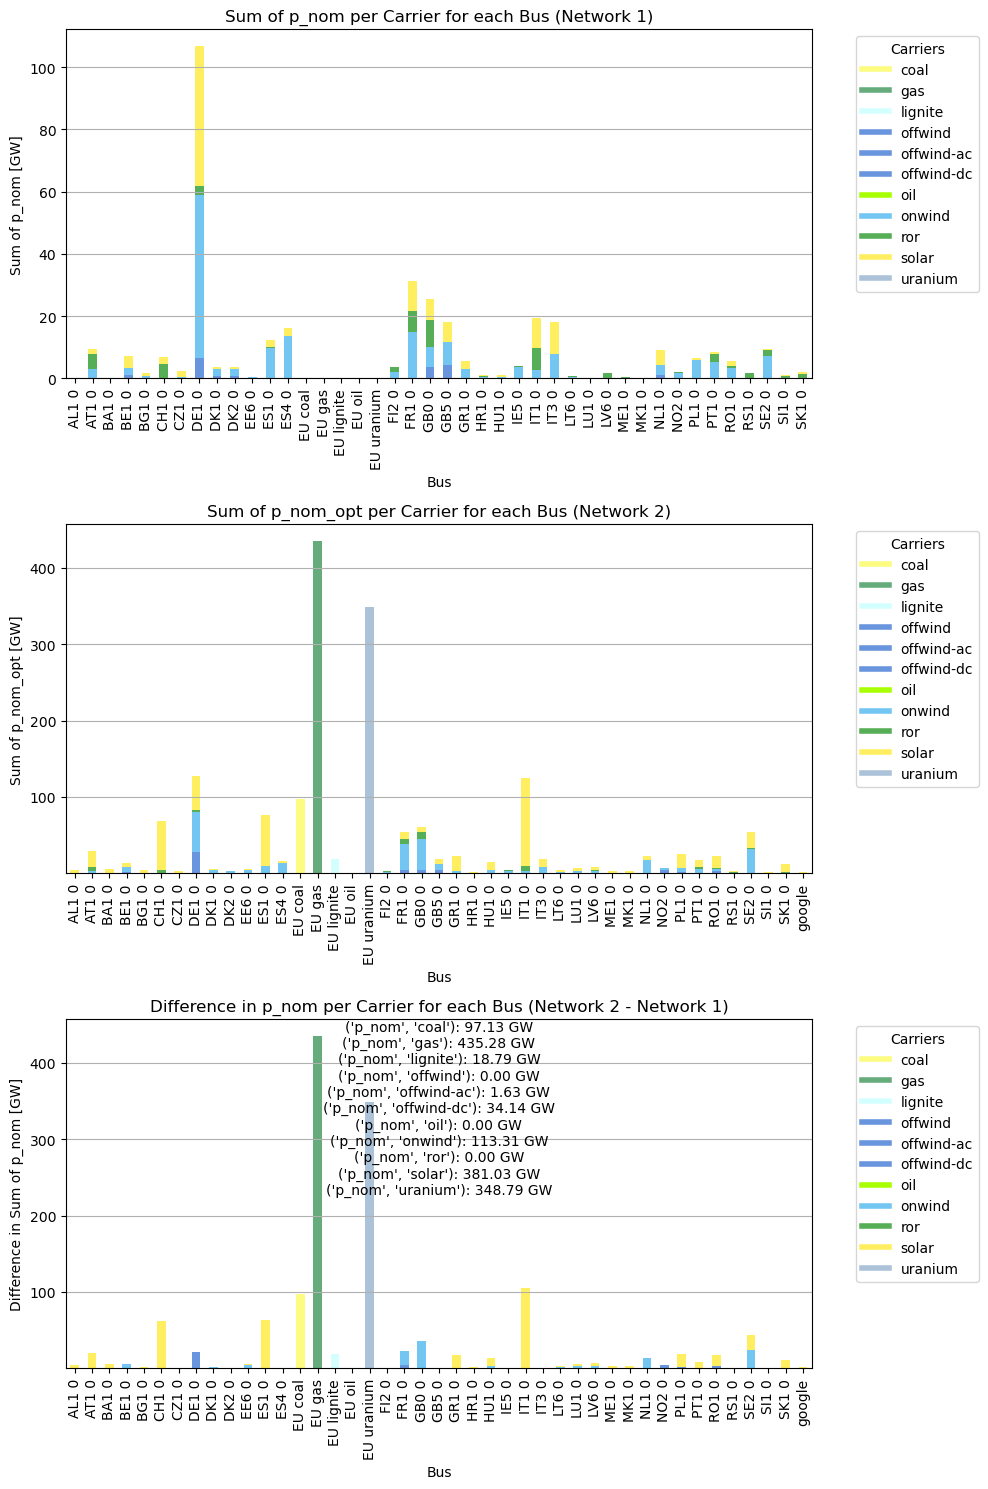

In [12]:
n1 = pypsa.Network('../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025_fix_vre_SARAH.nc')# results/12_13_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc')# 
n2 = pypsa.Network('../results/12_07_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc')
plot_capacity_summaries(n1,n2)

Index(['AL1 0 residential rural biomass boiler-2025',
       'AT1 0 residential rural biomass boiler-2025',
       'BA1 0 residential rural biomass boiler-2025',
       'BE1 0 residential rural biomass boiler-2025',
       'BG1 0 residential rural biomass boiler-2025',
       'CH1 0 residential rural biomass boiler-2025',
       'CZ1 0 residential rural biomass boiler-2025',
       'DE1 0 residential rural biomass boiler-2025',
       'DK1 0 residential rural biomass boiler-2025',
       'DK2 0 residential rural biomass boiler-2025',
       ...
       'MK1 0 services urban decentral biomass boiler-2025',
       'NL1 0 services urban decentral biomass boiler-2025',
       'NO2 0 services urban decentral biomass boiler-2025',
       'PL1 0 services urban decentral biomass boiler-2025',
       'PT1 0 services urban decentral biomass boiler-2025',
       'RO1 0 services urban decentral biomass boiler-2025',
       'RS1 0 services urban decentral biomass boiler-2025',
       'SE2 0 services

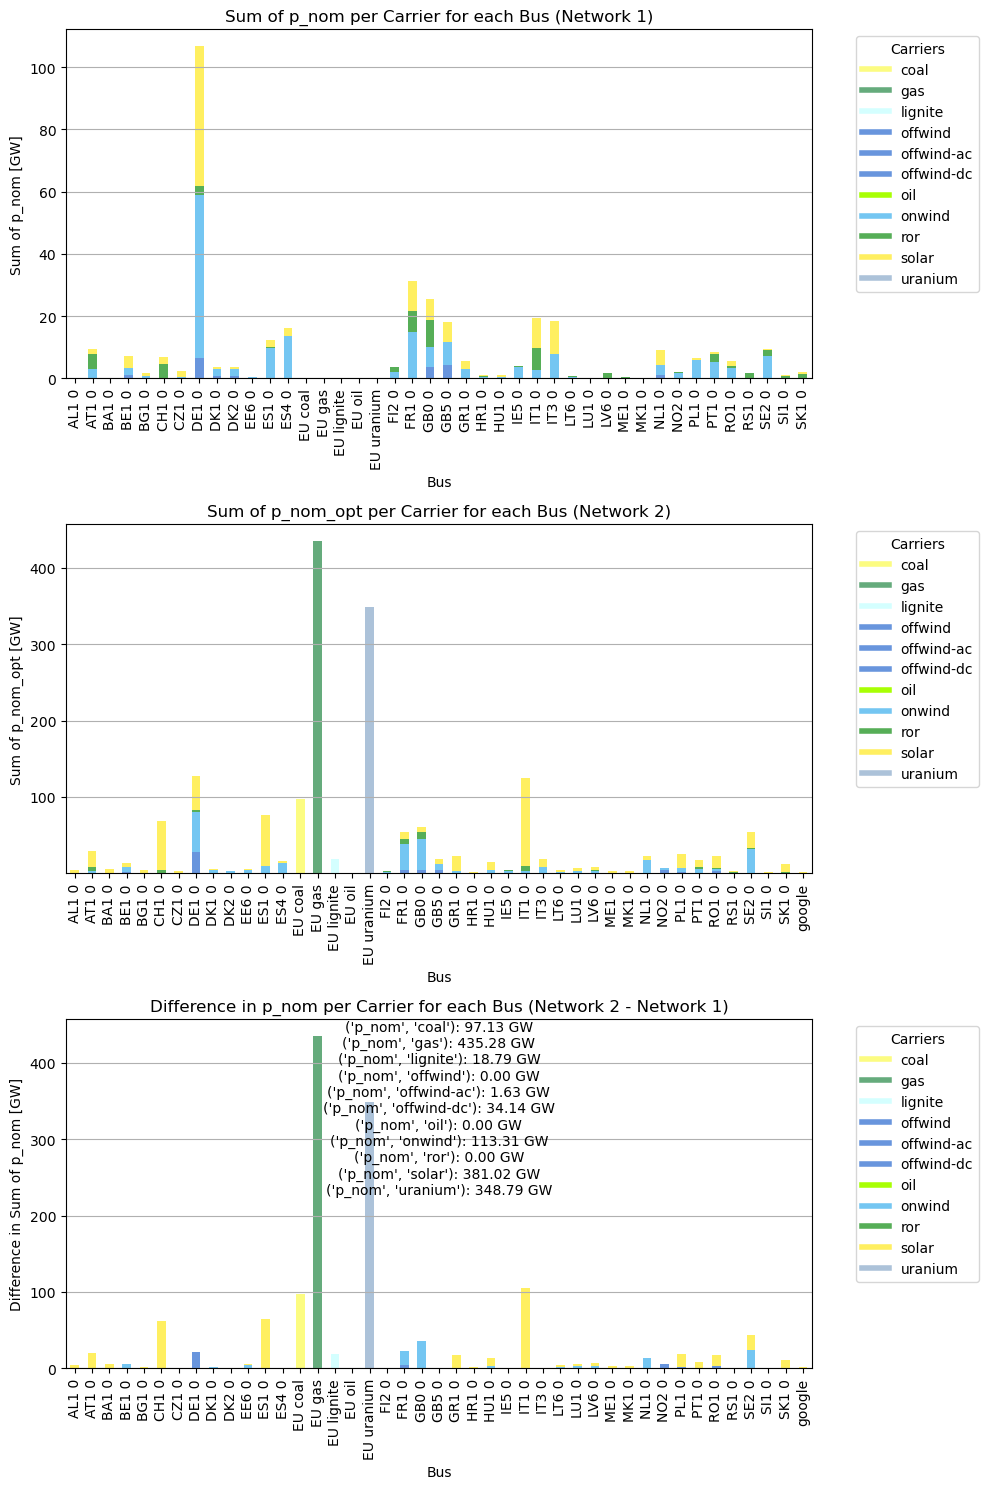

In [13]:
n1 = pypsa.Network('../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc')#'../../pypsa-eur/results/weatheryeartest/prenetworks/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc') #'../results/validationEU/networks/10/2025/IE/p1/2013/res100.nc') 
n2 = pypsa.Network('../results/12_07_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc') #'../input/v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc') #'../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc') #
plot_capacity_summaries(n1,n2)

# Comparison of p_nom_max and p_nom_opt


In [31]:
def plot_bar_charts_adjacent(n):
    # Define the color scheme
    tech_colors = {
        "offwind": "#6895dd",  # offshore wind
        "onwind": "#74c6f2",   # onshore wind
        "ror": "#298c81",      # run of river
        "solar": "#ffef60"     # solar
    }

    # Adjust carrier names for offwind variants
    n.generators['carrier'] = n.generators['carrier'].replace(['offwind-dc', 'offwind-ac'], 'offwind')

    # Filter only relevant columns
    relevant_carriers = ['offwind', 'onwind', 'ror', 'solar']
    filtered_gens = n.generators[n.generators['carrier'].isin(relevant_carriers)]

    # Data for extendable and non-extendable generators
    extendable_gens = filtered_gens[filtered_gens.p_nom_extendable]
    extended_gens = extendable_gens[extendable_gens.p_nom_opt > 0]
    non_extendable_gens = filtered_gens[~filtered_gens.p_nom_extendable]

    # Group and sum data
    sum_extendable = extendable_gens.groupby(['bus', 'carrier']).p_nom_max.sum().unstack(fill_value=0).div(1000)
    sum_extended = extended_gens.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack(fill_value=0).div(1000)
    sum_non_extendable = non_extendable_gens.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack(fill_value=0).div(1000)

    # Ensure both dataframes have the same index and columns
    common_index = sum_extendable.index.union(sum_non_extendable.index)
    common_columns = relevant_carriers
    sum_extendable = sum_extendable.reindex(index=common_index, columns=common_columns, fill_value=0)
    sum_extended = sum_extended.reindex(index=common_index, columns=common_columns, fill_value=0)
    sum_non_extendable = sum_non_extendable.reindex(index=common_index, columns=common_columns, fill_value=0)

    # Plotting
    fig, ax = plt.subplots(3,1,figsize=(15, 15))

    # Width of a bar
    bar_width = 0.2

    # Positions of the extendable and non-extendable bars
    index = np.arange(len(common_index))
    extendable_pos = index + bar_width
    extended_pos = index
    non_extendable_pos = index - bar_width

    """# Stacked bar chart for extendable generators
    bottom = np.zeros(len(common_index))
    for col in sum_extendable.columns:
        ax[0].bar(extendable_pos, sum_extendable[col], bar_width, bottom=bottom, color=tech_colors.get(col, '#333333'), label='Ext: ' + col if np.all(bottom == 0) else "")
        bottom += sum_extendable[col].values"""
        
    #stacked bar chart for extended generators
    bottom = np.zeros(len(common_index))
    for col in sum_extended.columns:
        ax[0].bar(extended_pos, sum_extended[col], bar_width, bottom=bottom, color=tech_colors.get(col, '#333333'), label='Ext: ' + col if np.all(bottom == 0) else "")
        bottom += sum_extended[col].values

    # Stacked bar chart for non-extendable generators
    bottom = np.zeros(len(common_index))
    for col in sum_non_extendable.columns:
        ax[0].bar(non_extendable_pos, sum_non_extendable[col], bar_width, bottom=bottom, color=tech_colors.get(col, '#333333'), label='Non-Ext: ' + col if np.all(bottom == 0) else "")
        bottom += sum_non_extendable[col].values

    ax[0].set_xlabel('Bus')
    ax[0].set_ylabel('Generator Capacity [GW]')
    ax[0].set_title('Extendable and Non-Extendable Generator Capacities by Bus and Carrier')
    ax[0].set_xticks(index)
    ax[0].set_xticklabels(common_index, rotation=90)
    ax[0].legend()
    
    # Plot 2: Bar Chart for Quotients
    quotient = sum_non_extendable.div(sum_extendable.where(sum_extendable != 0, 0.000001))  # Avoid division by zero
    quotient.pop('ror')  # Remove run of river generators
    quotient.plot(kind='bar', ax=ax[1], color=[tech_colors.get(x, '#333333') for x in quotient.columns])
    ax[1].set_title('Quotient of already build capacity (<2020) and maximum potential per Carrier')
    ax[1].set_ylabel('Quotient')
    
    # Plot 3: Bar Chart for Quotients
    quotient = sum_extended.div(sum_non_extendable.where(sum_non_extendable != 0, 0.000001))  # Avoid division by zero
    quotient.pop('ror')  # Remove run of river generators
    quotient.plot(kind='bar', ax=ax[2], color=[tech_colors.get(x, '#333333') for x in quotient.columns])
    ax[2].set_title('Quotient of extended capacity (>2020) and already build capacity (<2020) per Carrier')
    ax[2].set_ylabel('Quotient')


    plt.tight_layout()
    plt.show()

INFO:pypsa.io:Imported network res100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


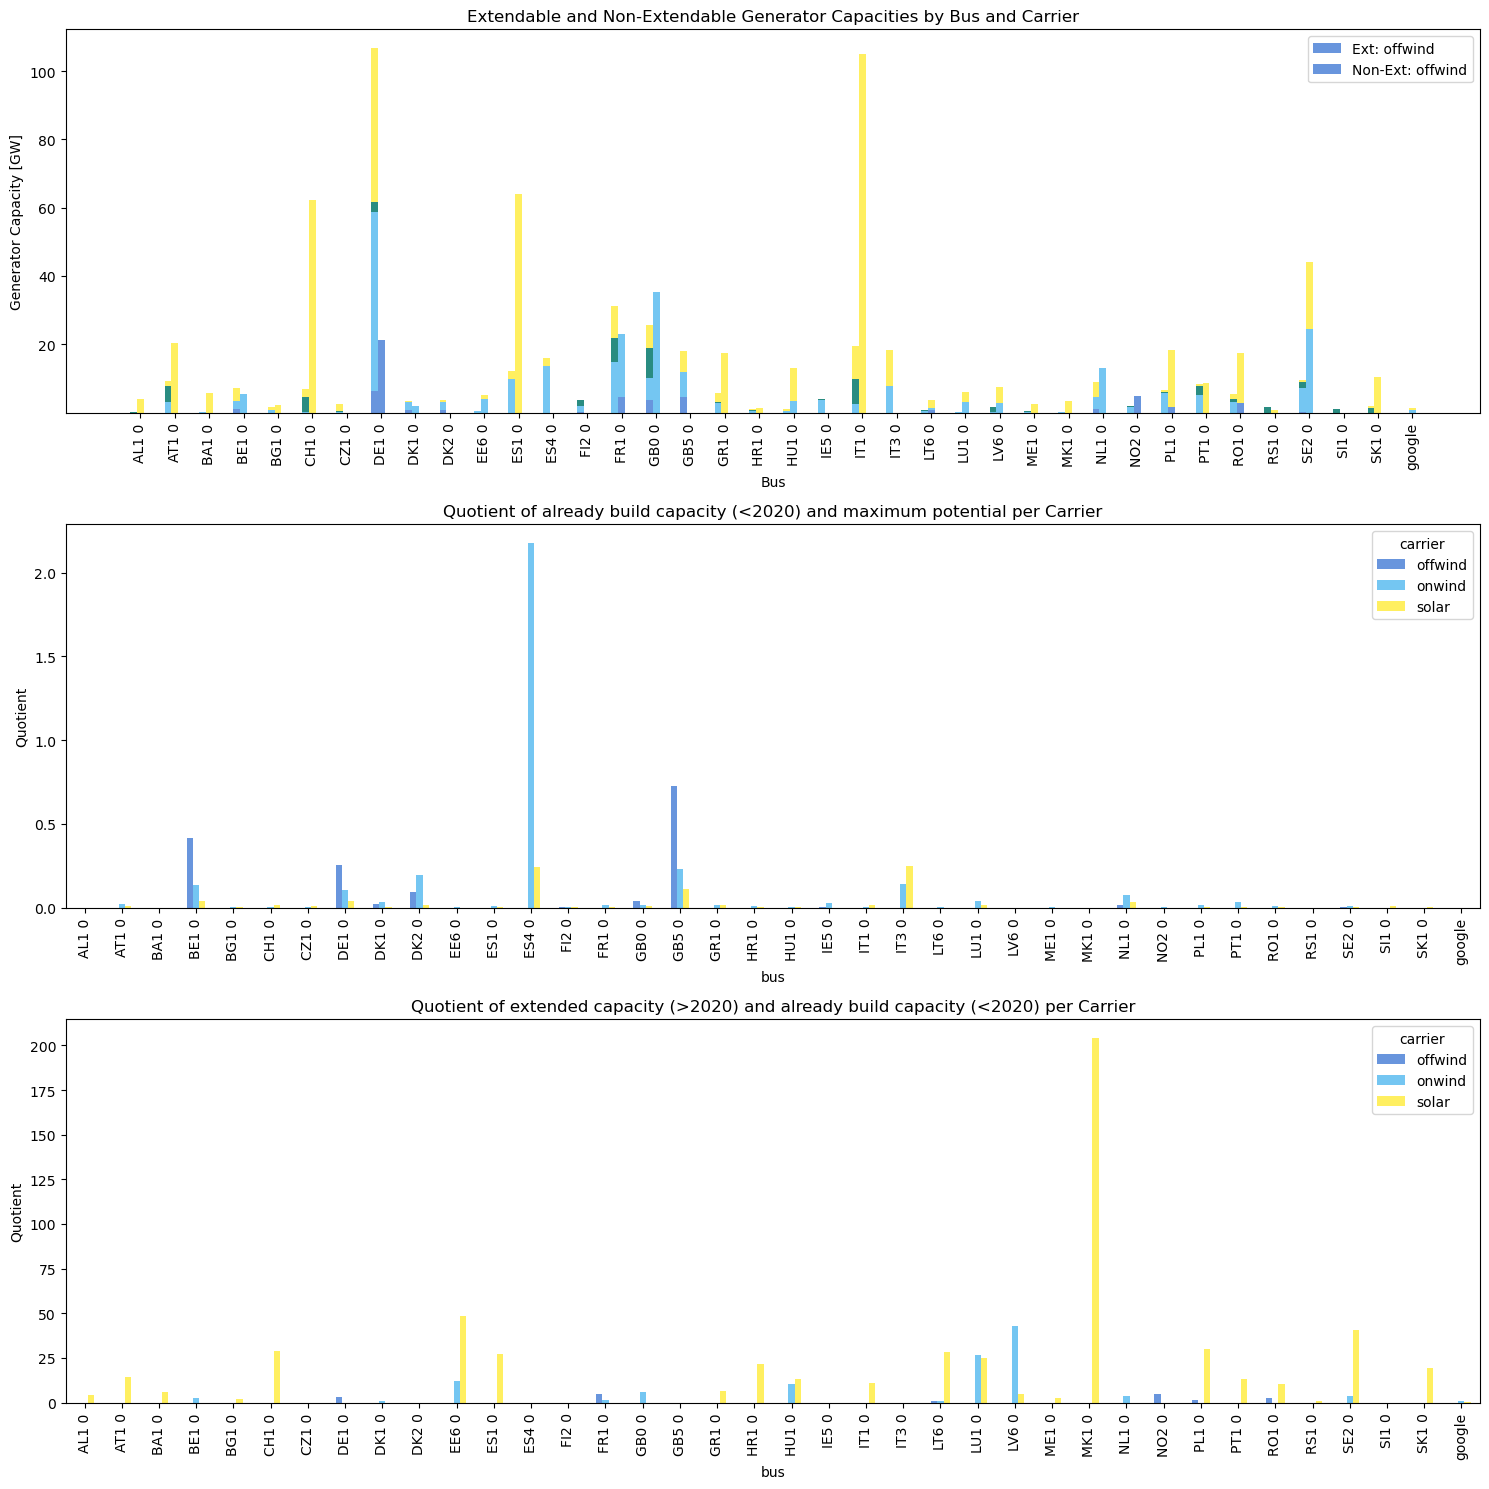

In [27]:
n = pypsa.Network('../results/12_07_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc')
plot_bar_charts_adjacent(n)

INFO:pypsa.io:Imported network res100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
/home/tillotillson/mambaforge/envs/247-env/lib/python3.11/site-packages/matplotlib/transforms.py:2042: RuntimeWarning:

invalid value encountered in scalar add

/home/tillotillson/mambaforge/envs/247-env/lib/python3.11/site-packages/matplotlib/transforms.py:383: RuntimeWarning:

invalid value encountered in scalar subtract



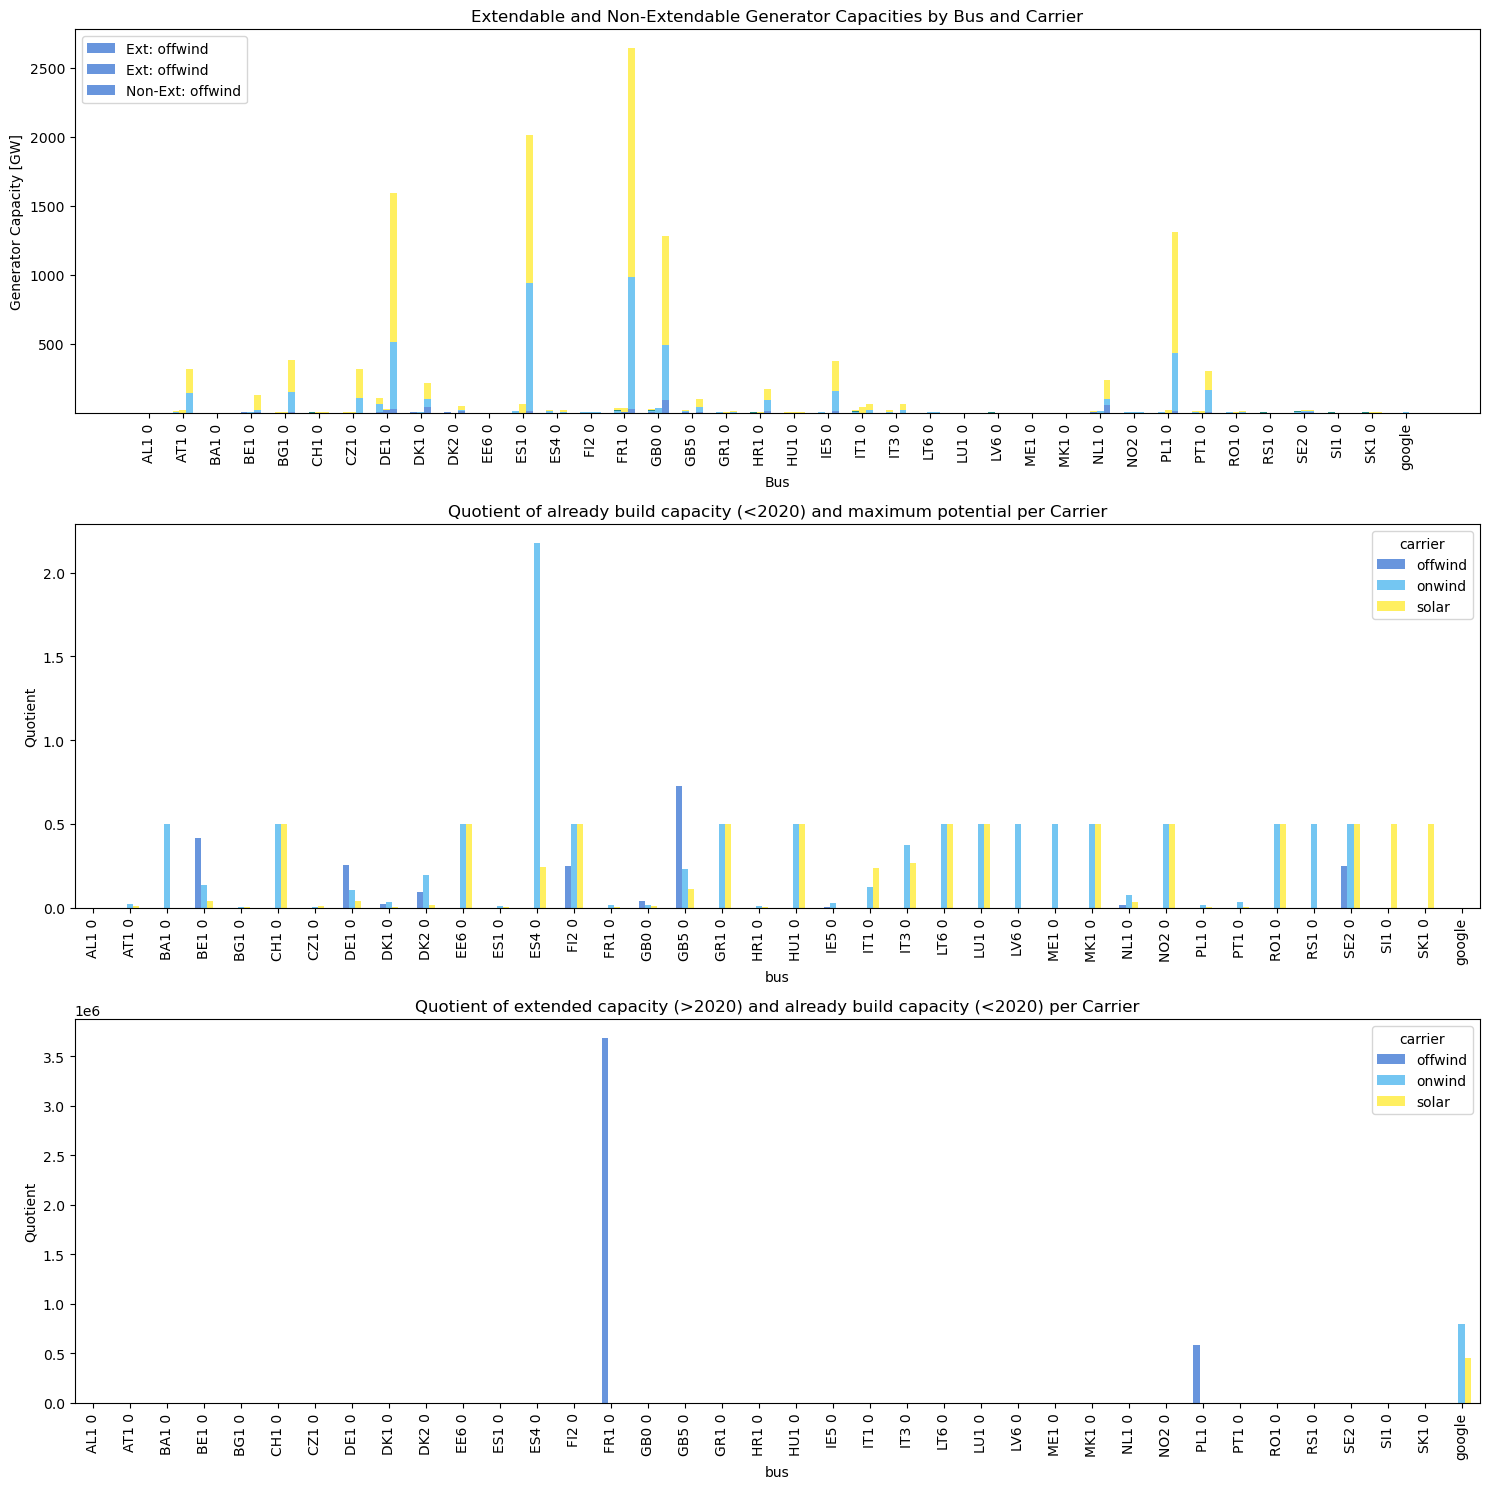

In [32]:
n = pypsa.Network('../results/01_02_validationEU_limitres/networks/10/2025/IE/p1/2013/res100.nc')
plot_bar_charts_adjacent(n)